# Plotly Endpoint - Dashbaord

***

## Libraries

In [2]:
import requests
import plotly.graph_objs as go
import json
import boto3
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

In [3]:
! pip install -U kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 229.5 MB/s eta 0:00:00a 0:00:01


In [4]:
#Get EndPoint
%store -r final_endpoint

In [5]:
endpoint_name = final_endpoint
region_name = boto3.Session().region_name
runtime_client = boto3.client('sagemaker-runtime', region_name=region_name)

***

## Get data from Endpoint

In [6]:
data = {
    'instances': [
        {
            'start': '2023-04-01 00:00:00',
            'target': [0.1, 0.2, 0.3, 0.4, 0.5],
        }
    ],
    'configuration': {
        'num_samples': 100,
        'output_types': ['mean', 'quantiles', 'samples'],
        'quantiles': ['0.1', '0.5', '0.9']
    }
}

# Convert the payload to JSON
payload = json.dumps(data)

In [7]:
# Send a request to the endpoint with the payload
response = runtime_client.invoke_endpoint(EndpointName=endpoint_name,
                                          ContentType='application/json',
                                          Body=payload)

# Read the response and parse it as JSON
response_body = response['Body']
result = json.loads(response_body.read().decode())

***

## Vizualize

In [8]:
# Extract the forecasted and quantiles from the response data
forecast_data = result['predictions'][0]['mean']
Q1= result['predictions'][0]['quantiles']['0.1']
Q5= result['predictions'][0]['quantiles']['0.5']
Q9= result['predictions'][0]['quantiles']['0.9']

df = pd.DataFrame({
    'timestamp': pd.date_range(start='2023-04-01 00:00:00', periods=len(forecast_data), freq='H'),
    'forecast': forecast_data,
    'Q1': Q1,
    'Q5': Q5,
    'Q9': Q9
})


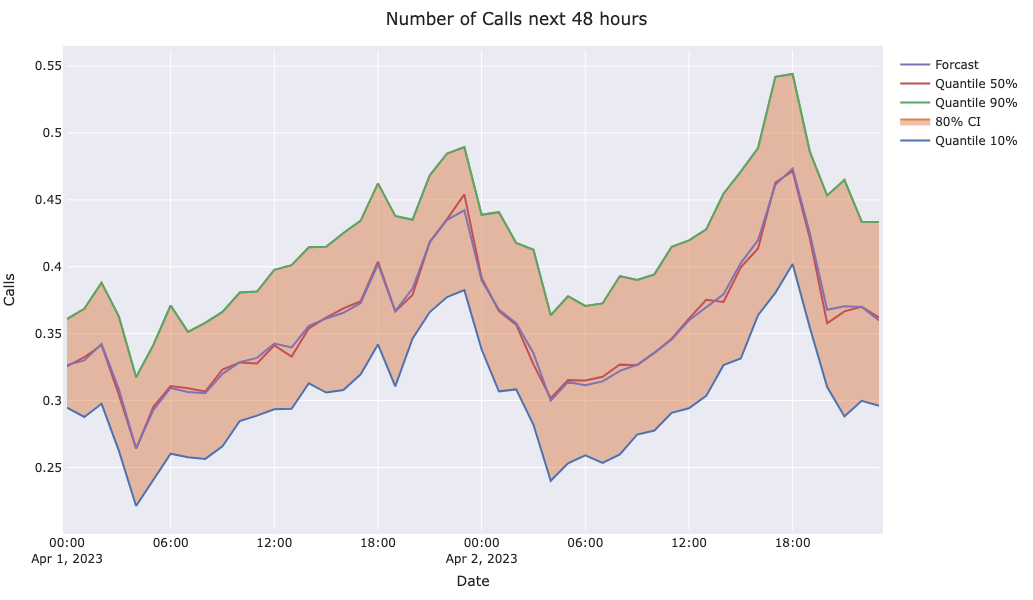

In [17]:
# create the chart
fig = go.Figure()

time=df['timestamp']
CI_90=df['Q9']
CI_10=df['Q1']
CI_50=df['Q5']
forcast = df['forecast']

trace_10 = go.Scatter(x=time, y=CI_10, mode='lines', name='Quantile 10%')
fill_trace = go.Scatter(x=time, y=CI_90, mode='lines', name='80% CI', fill='tonexty')
trace_90 = go.Scatter(x=time, y=CI_90, mode='lines', name='Quantile 90%')
trace_50 = go.Scatter(x=time, y=CI_50, mode='lines', name='Quantile 50%')
trace_forcast = go.Scatter(x=time, y=forcast, mode='lines', name='Forcast')

fig = go.Figure([
    trace_10,
    fill_trace,
    trace_90,
    trace_50,
    trace_forcast,
])

fig.update_layout(
    title='Number of Calls next 48 hours',
    xaxis_title='Date',
    yaxis_title='Calls',
    autosize=False,
    width=1000,
    height=600,
    template='seaborn',
    margin=dict(
        l=50,
        r=25,
        b=10,
        t=50,
        pad=4
    ),
    #paper_bgcolor="ggplot2",
)

#filename = 'endpoint_forecast.png'
#path = 'Images/' + filename
#fig.write_image(path)
fig.show()